In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import namedtuple, deque


In [2]:
!killall 9-swarm.x86_64
from mlagents.envs import UnityEnvironment
import numpy as np

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Replay Buffer</h2>

In [5]:
class ReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.capacity = capacity
        self.buffer = []
        self.batch_size = batch_size
        self.position = 0
    
    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [6]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

In [7]:

class ReplayBuffer2:
    " Internal memory of the agent "
    
    def __init__(self, buffer_size, batch_size, n_agents=1, seed=0):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        
        self.n_agents = n_agents
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        " Add a new experience to memory "
        for i in range(self.n_agents):
            e = self.experience(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
            self.memory.append(e)
        
    def sample(self):
        " Randomly sample a batch of experiences from the memory "
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
#         print(dones.shape)
#         dones = done.squeeze(axis = 1)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        " Return the current size of internal memory. Overwrites the inherited function len. "
        
        return len(self.memory)
        
    
    



In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor</h1>
<h2><a href="https://arxiv.org/abs/1801.01290">Arxiv</a></h2>

In [9]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, 400)
        self.linear2 = nn.Linear(400, 300)
        
        self.mean_linear = nn.Linear(300, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(300, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)
        
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z      = normal.sample()
        action = torch.tanh(z)
#         action = mean
        action  = action.detach().cpu().numpy()
#         print(action)
        return action[0]

In [10]:
def soft_q_update(batch_size, 
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=0.0,
           soft_tau=1e-2,
          ):
    state, action, reward, next_state, done = replay_buffer.sample()

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    expected_q_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)


    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(state, new_action)
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
#     print(policy_loss.item(),log_prob[0],expected_new_q_value[0])

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()

    policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
    return policy_loss.item()

In [11]:
def soft_q_update1(batch_size):
    gamma=0.99
    soft_tau=1e-2
    alpha = 0.2
    mean_lambda=1e-3
    std_lambda=1e-3
    z_lambda=0.0
    state, action, reward, next_state, done = replay_buffer.sample()
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).to(device)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)
    v_target = target_value_net(next_state)
    q1 = soft_q_net(state, action)
    q2 = soft_q2_net(state, action)
    v = value_net(state)
    q_bak = (reward + (1 - done) * gamma * v_target).detach()
    q1_pi = soft_q_net(state, new_action)
    q2_pi = soft_q2_net(state, new_action)
    min_q_pi = torch.min(q1_pi, q2_pi)
    
    v_bak = (min_q_pi - alpha*log_prob).detach()
    pi_loss = (alpha*log_prob - min_q_pi).mean()
    q1_loss = 0.5*F.mse_loss(q1,q_bak)
    q2_loss = 0.5*F.mse_loss(q2,q_bak)
    v_loss = 0.5*F.mse_loss(v,v_bak)
    
    
    log_prob_target = q1_pi - v
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()
    
    policy_loss += mean_loss + std_loss + z_loss
    policy_optimizer.zero_grad()
    pi_loss.backward()
    policy_optimizer.step()
    
    soft_q_optimizer.zero_grad()
    q1_loss.backward()
    soft_q_optimizer.step()
    soft_q2_optimizer.zero_grad()
    q2_loss.backward()
    soft_q2_optimizer.step()
    value_optimizer.zero_grad()
    v_loss.backward()
    value_optimizer.step()
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
    return v_loss.item()

In [12]:
def soft_q_update2(batch_size):
    gamma=0.99
    soft_tau=1e-2
    alpha = 0.2
    mean_lambda=1e-3
    std_lambda=1e-3
    z_lambda=0.0
    state, action, reward, next_state, done = replay_buffer.sample()
    state      = torch.FloatTensor(state).squeeze(1).to(device)
    next_state = torch.FloatTensor(next_state).squeeze(1).to(device)
    action     = torch.FloatTensor(action).squeeze(1).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).to(device)
#     print(state.shape, action.shape, next_state.shape, done.shape)
#     print(1 - done)
    with torch.no_grad():
        v_target = target_value_net(next_state)
        next_q_value = reward + (1 - done) * gamma * (v_target)
#         print('next q: ',next_q_value)
    q1 = soft_q_net(state, action)
    q1_loss = F.mse_loss(q1, next_q_value)
    q2 = soft_q2_net(state, action)
    q2_loss = F.mse_loss(q2, next_q_value)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)
    q1_pi = soft_q_net(state, new_action)
    q2_pi = soft_q2_net(state, new_action)
    min_q_pi = torch.min(q1_pi,q2_pi)
    policy_loss = ((alpha * log_prob) - min_q_pi).mean()
#     reg_loss = 0.001 * (mean.pow(2).mean() + log_std.pow(2).mean())
#     policy_loss += reg_loss
    
    vf = value_net(state)
    with torch.no_grad():
        vf_target = min_q_pi - (alpha * log_prob)
    
    vf_loss = F.mse_loss(vf, vf_target)
    
    
#     log_prob_target = q1_pi - vf
#     policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

#     mean_loss = mean_lambda * mean.pow(2).mean()
#     std_loss  = std_lambda  * log_std.pow(2).mean()
#     z_loss    = z_lambda    * z.pow(2).sum(1).mean()
    
#     policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q1_loss.backward()
    soft_q_optimizer.step()
    soft_q2_optimizer.zero_grad()
    q2_loss.backward()
    soft_q2_optimizer.step()
    value_optimizer.zero_grad()
    vf_loss.backward()
    value_optimizer.step()
    

    
#     soft_q2_optimizer.zero_grad()
#     q2_loss.backward()
#     soft_q2_optimizer.step()
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
    return policy_loss.item()

In [13]:
from mlagents.envs import UnityEnvironment
import numpy as np
env = NormalizedActions(gym.make("Pendulum-v0"))
# env = UnityEnvironment(file_name = \
#                        '/home/ohk/Downloads/ContinuousControl-D4PG-master/Reacher_Linux/9-swarm.x86_64',
#                       no_graphics=False,base_port=10001)

In [14]:
# get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]
# print(brain_name)
# print(brain)

In [15]:
# # reset the environment
# print('reset the environment')
# env_info = env.reset(train_mode=True)[brain_name]
# print('finished reset')
# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_dim = brain.vector_action_space_size[0]
# print('Size of each action:', action_dim)

# # examine the state space 
# states = env_info.vector_observations
# state_dim = states.shape[1] #ndarray
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], states.shape))
# print('The state for the first agent looks like:', states[0])

In [16]:
states = env.reset()
num_agents = 1
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

In [17]:
finished = False
if( finished ):
    env.close()

In [18]:
# env_info = env.reset(train_mode=True)[brain_name]

In [19]:
import torch
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
p_l = []

In [21]:

hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q2_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)


value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 1e-2


value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=value_lr)
soft_q2_optimizer = optim.Adam(soft_q2_net.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=value_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size, batch_size)

In [22]:
max_frames  = 10000

In [23]:
# while frame_idx < max_frames:
#     state = env.reset()
#     episode_reward = 0
#     
#     for step in range(max_steps):
#         action = policy_net.get_action(state)
#         next_state, reward, done, _ = env.step(action)
# #         env.render()
#         replay_buffer.push(state, action, reward, next_state, done)
#         if len(replay_buffer) > batch_size:
#             l = soft_q_update(batch_size)
#             p_l.append(l)
#         
#         state = next_state
#         episode_reward += reward
#         frame_idx += 1
#         
#         if frame_idx % 1000 == 0:
# #             plot(frame_idx, rewards)
#             plot(frame_idx, p_l)
#             print(episode_reward)
#         if done:
#             break
#         
#     rewards.append(episode_reward)


In [24]:
print(env)
scores = []
policy_loss = []
import datetime

<NormalizedActions<TimeLimit<PendulumEnv<Pendulum-v0>>>>


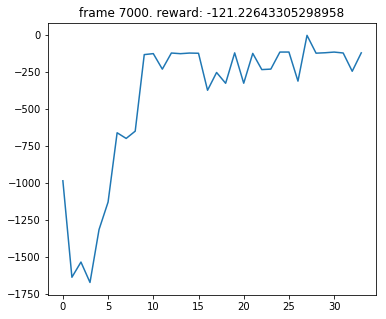

35 1.7688100337982178
episode  36  start at  2019-05-21 21:07:27.633801
36 1.6902875900268555
episode  37  start at  2019-05-21 21:07:29.324154
37 1.700530767440796
episode  38  start at  2019-05-21 21:07:31.024765


KeyboardInterrupt: 

In [25]:
timestep = 0
rewards = []
for i_episode in range(1, 100):
    st = time.time()
    episode_r = 0
    print('episode ',i_episode,' start at ',datetime.datetime.now())
#     env_info = env.reset(train_mode=True)[brain_name]
    
#     state = env_info.vector_observations
    state = np.array([env.reset()])
#     print(state)
    score = np.zeros(num_agents)
    for t in range(5000):
        action = np.zeros((num_agents, action_dim)) # initialize multidimensional array actions of each agent
        for i in range(num_agents):
                state_i = torch.from_numpy(state[i,:]).float()
                with torch.no_grad():
#                     print('state ',i,state_i.shape)
                    action[i,:] =  policy_net.get_action(state_i)
#         print(action)
        env_info = env.step(action[0])#[brain_name]
#         print(env_info)
#         next_state = np.array([np.transpose(env_info[0])])
#         next_state = np.array([[env_info[0]]])
#         reward = np.array([env_info[1]])                        # get reward (for each agent)
#         done = np.array([env_info[2]])
        next_state = np.array([env_info[0]])
#         print('next_', next_state)
        reward = env_info[1]
        done = env_info[2]
        
        score += reward
#         print(env_info)
#         print('add ', state, state.shape)
#         print('done',done.shape)
#         print(state, action, reward, next_state, done)
#         print(state)
        replay_buffer.add(state,action,reward,next_state,done)
        if len(replay_buffer) > batch_size:
            policy_l = soft_q_update2(batch_size)
            policy_loss.append(policy_l)
        state = next_state
        timestep += 1
        episode_r += np.sum(reward)
        
        if timestep % 1000 == 0:
            plot(timestep, rewards)
        if np.any(done):
            break
    rewards.append(episode_r)
    print(i_episode,time.time()-st)

In [ ]:
print(i_episode)
